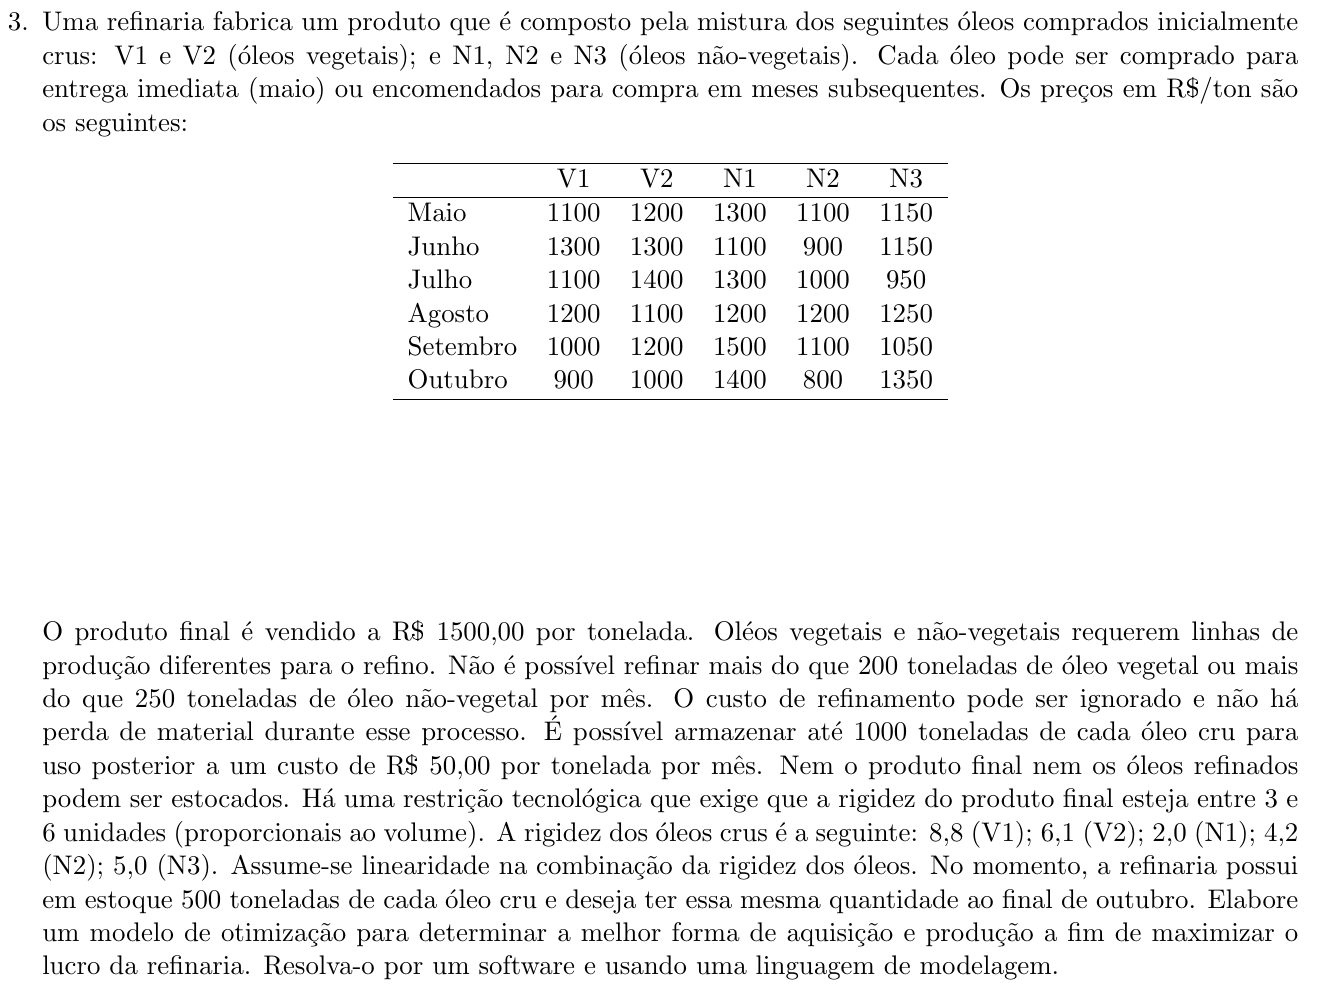

In [9]:
from IPython.display import Image
Image(filename='images/3.png')

In [4]:
# Módulos
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [5]:
# Conjuntos
Oleos = ['V1', 'V2', 'N1', 'N2', 'N3']
Vegetais = ['V1', 'V2']
Nao_vegetais = ['N1', 'N2', 'N3']
Meses = [4, 5, 6, 7, 8, 9, 10]
# Parâmetros
custo_oleo_M_O = {(4, 'V1'): 0, (4, 'V2'): 0, (4, 'N1'): 0, (4, 'N2'): 0, (4, 'N3'): 0,
                  (5, 'V1'): 1100, (5, 'V2'): 1200, (5, 'N1'): 1300, (5, 'N2'): 1100, (5, 'N3'): 1150,
                  (6, 'V1'): 1300, (6, 'V2'): 1300, (6, 'N1'): 1100, (6, 'N2'): 900, (6, 'N3'): 1150,  
                  (7, 'V1'): 1100, (7, 'V2'): 1400, (7, 'N1'): 1300, (7, 'N2'): 1000, (7, 'N3'): 950, 
                  (8, 'V1'): 1200, (8, 'V2'): 1100, (8, 'N1'): 1200, (8, 'N2'):1200, (8, 'N3'): 1250, 
                  (9, 'V1'): 1000, (9, 'V2'): 1200, (9, 'N1'): 1500, (9, 'N2'): 1100, (9, 'N3'): 1050,  
                  (10, 'V1'): 900, (10, 'V2'): 1000, (10, 'N1'): 1400, (10, 'N2'): 800, (10, 'N3'): 1350}
preco = 1500
capacidade_refino_vegetal = 200
capacidade_refino_nao_vegetal = 250
custo_estoque = 50
capacidade_estoque = 1000
rigidez_vegetais = {'V1': 8.8, 'V2': 6.1}
rigidez_nao_vegetais = {'N1': 2, 'N2': 4.2, 'N3': 5}


In [6]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.O = Set(initialize=Oleos)
model.V = Set(initialize=Vegetais)
model.N = Set(initialize=Nao_vegetais)
model.M = Set(initialize=Meses)
O, V, N, M = model.O, model.V, model.N, model.M

# Parâmetros
model.c = Param(M * O, initialize=custo_oleo_M_O, within=NonNegativeReals)
model.rv = Param(V, initialize=rigidez_vegetais, within=NonNegativeReals)
model.rn = Param(N, initialize=rigidez_nao_vegetais, within=NonNegativeReals)
model.p = Param(initialize=preco, within=NonNegativeReals)
model.C = Param(initialize=capacidade_refino_vegetal, within=NonNegativeReals)
model.B = Param(initialize=capacidade_refino_nao_vegetal, within=NonNegativeReals)
model.h = Param(initialize=custo_estoque, within=NonNegativeReals)
model.g = Param(initialize=capacidade_estoque, within=NonNegativeReals)
c, rv, rn, p, C, B, h, g = model.c, model.rv, model.rn, model.p, model.C, model.B, model.h, model.g

# Variáveis de decisão
model.q = Var(O * M, within=NonNegativeReals)
model.x = Var(V * M, within=NonNegativeReals)
model.y = Var(N * M, within=NonNegativeReals)
model.I = Var(O * M, within=NonNegativeReals)
model.S = Var(M, within=NonNegativeReals)
q, x, y, I, S = model.q, model.x, model.y, model.I, model.S

# Função objetivo
model.obj = Objective(sense=maximize,
                      expr=sum(p * S[t] for t in M if t > 4) - sum(sum(c[t, i] * q[i, t] + h * I[i, t] for i in O) for t in M if t > 4))

# Restrições
# Conservação de estoque
model.r_conservacao = ConstraintList()
for j in V:
  for t in M:
    if t > 4:
      model.r_conservacao.add(expr= q[j, t] + I[j, t-1] == I[j, t] + x[j, t])
for k in N:
  for t in M:
    if t > 4:
      model.r_conservacao.add(expr= q[k, t] + I[k, t-1] == I[k, t] + y[k, t])
# Refino de oleo vegetal
model.r_refino_veg = ConstraintList()
for t in M:
  if t > 4:
    model.r_refino_veg.add(expr = sum(x[j, t] for j in V) <= C)
# Refino de oleo nao vegetal
model.r_refino_nveg = ConstraintList()
for t in M:
  if t > 4:
    model.r_refino_nveg.add(expr = sum(y[k, t] for k in N) <= B)
# Armazenagem
model.r_armazenagem = ConstraintList()
for i in O:
  model.r_armazenagem.add(expr=I[i, 4] == 500)
  model.r_armazenagem.add(expr=I[i, 10] == 500)
  for t in M:
    if t > 4:
      model.r_armazenagem.add(expr = I[i, t] <= g)
# Rigidez
#model.r_rigidez = ConstraintList()
#for t in M:
#  if t > 4:
#    model.r_rigidez.add(expr = sum(rv[j] * x[j, t] for j in V) + sum(rn[k] * y[k, t] for k in N) >= 3)
#    model.r_rigidez.add(expr = sum(rv[j] * x[j, t] for j in V) + sum(rn[k] * y[k, t] for k in N) <= 6)
# Vendas
model.r_vendas = ConstraintList()
for t in M:
  if t > 4:
    model.r_vendas.add(expr = S[t] == sum(x[j, t] for j in V) + sum(y[k, t] for k in N))

# model.pprint()

In [7]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee=False)

In [8]:
# Apresentação de resultados
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
  for i in O:
    for t in M:
      if t > 4:
        if value(q[i,t]) > 0:
          print('Foram compradas {} unidades do óleo {} no mês {}'.format(value(q[i,t]), i, t))
          #print('Foram estocadas {} unidades do óleo {} no mês {}'.format(value(I[i,t]), i, t))
  for t in M:
    if t > 4:
      print('Foram vendidas {} toneladas no mes {}'.format(value(S[t]), t))
  print('O lucro máximo é de ${:.2f}'.format(value(model.obj)))
else:
    print(resultado.solver.termination_condition)

Foram compradas 700.0 unidades do óleo V1 no mês 10
Foram compradas 500.0 unidades do óleo V2 no mês 10
Foram compradas 750.0 unidades do óleo N2 no mês 10
Foram compradas 750.0 unidades do óleo N3 no mês 7
Foram vendidas 450.0 toneladas no mes 5
Foram vendidas 450.0 toneladas no mes 6
Foram vendidas 450.0 toneladas no mes 7
Foram vendidas 450.0 toneladas no mes 8
Foram vendidas 450.0 toneladas no mes 9
Foram vendidas 450.0 toneladas no mes 10
O lucro máximo é de $1082500.00
